In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
from pylab import *
from astropy.io import ascii
import scipy.constants as const
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel
from lmfit import Model, Parameters

# Data Loading

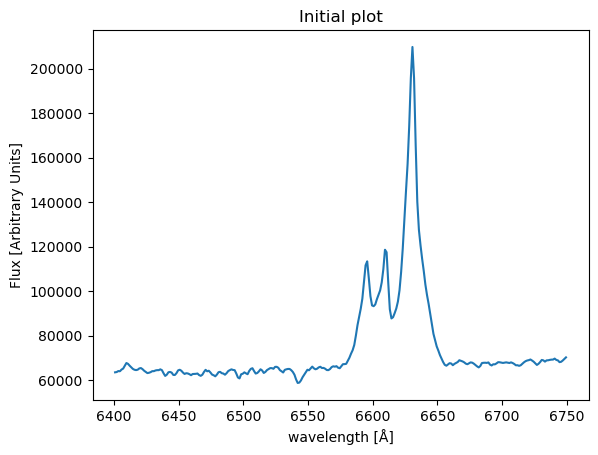

In [11]:
galaxy = "NGC1266"

tab_nuc = ascii.read(galaxy+"_nuc.dat")
wl_nuc = np.array(tab_nuc["Wavelength"])
fn_nuc = np.array(tab_nuc["Flux"])
region_of_interest_nuc = ((wl_nuc > 6400) & (wl_nuc < 6750))
wl_nuc, fn_nuc = wl_nuc[region_of_interest_nuc], fn_nuc[region_of_interest_nuc]

plt.plot(wl_nuc, fn_nuc)
plt.xlabel("wavelength [Å]")
plt.ylabel("Flux [Arbitrary Units]")
plt.title("Initial plot")
plt.show()

# Line Properties

In [12]:
contiuum_range = (wl_nuc < 6530) | (wl_nuc > 6660)
wl0 = 6564.61  # Ha Line
wlNIIleft = 6549.86
wlNIIright = 6585.27

# Continuum Removal

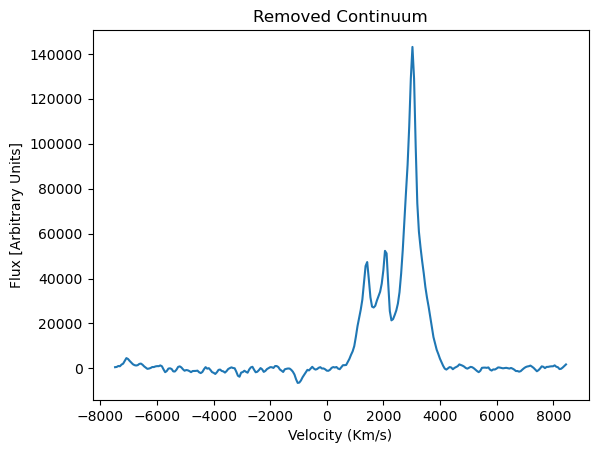

In [13]:
vel_nuc = (wl_nuc - wl0)/wl0 * const.c * 1.e-3  # Centering plot around Ha Line

cmod = LinearModel()
pars = cmod.make_params(intercept=median(fn_nuc[contiuum_range]), slope=0)
cfit = cmod.fit(fn_nuc[contiuum_range], pars, x=vel_nuc[contiuum_range])

fnc_nuc = fn_nuc - cfit.eval(x=vel_nuc)

plt.plot(vel_nuc, fnc_nuc)
plt.xlabel("Velocity (Km/s)")
plt.ylabel("Flux [Arbitrary Units]")
plt.title("Removed Continuum")
plt.show()

# Spectral Fitting

In [14]:
def Gaussian(x, amplitude, center, sigma):
    return amplitude * exp(- (x - center)**2 / (2 * sigma**2))


gauss1 = Model(Gaussian, prefix='g1_')  # Ηα
gauss2 = Model(Gaussian, prefix='g2_')  # ΝΙΙ Left
gauss3 = Model(Gaussian, prefix='g3_')  # NII Right

fmod = gauss1 + gauss2 + gauss3

parsGauss = Parameters()
parsGauss.add("g1_center", value=2000)
parsGauss.add("g2_center", value=1326, expr='-673.6026596401006+g1_center')
parsGauss.add("g3_center", value=2943.5004032654232,
              expr='943.5004032654232+g1_center')
parsGauss.add("g1_amplitude", value=0.35*max(fnc_nuc),
              min=0, max=0.45*max(fnc_nuc))
parsGauss.add("g2_amplitude", value=0.35*max(fnc_nuc),
              min=0, max=0.45*max(fnc_nuc))
parsGauss.add("g3_amplitude", value=max(fnc_nuc),
              min=0.95*max(fnc_nuc), max=1.15*max(fnc_nuc))
parsGauss.add("g1_sigma", value=100.)
parsGauss.add("g2_sigma", value=100.)
parsGauss.add("g3_sigma", value=100.)

ffit = fmod.fit(fnc_nuc, parsGauss, x=vel_nuc)

comps = ffit.eval_components(x=vel_nuc)

In [15]:
print(ffit.fit_report())

[[Model]]
    ((Model(Gaussian, prefix='g1_') + Model(Gaussian, prefix='g2_')) + Model(Gaussian, prefix='g3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 327
    # data points      = 280
    # variables        = 7
    chi-square         = 5.8512e+09
    reduced chi-square = 21432797.2
    Akaike info crit   = 4733.43222
    Bayesian info crit = 4758.87575
    R-squared          = 0.95568728
[[Variables]]
    g1_center:     2065.25908 +/- 4.17542392 (0.20%) (init = 2000)
    g2_center:     1391.65642 +/- 4.17542392 (0.30%) == '-673.6026596401006+g1_center'
    g3_center:     3008.75948 +/- 4.17542392 (0.14%) == '943.5004032654232+g1_center'
    g1_amplitude:  44418.1016 +/- 2232.57302 (5.03%) (init = 50070.43)
    g2_amplitude:  40773.5440 +/- 2145.28928 (5.26%) (init = 50070.43)
    g3_amplitude:  135905.462 +/- 2569.73813 (1.89%) (init = 143058.4)
    g1_sigma:      220.287859 +/- 14.4657024 (6.57%) (init = 100)
    g2_sigma:      233.990879 +/- 15.7

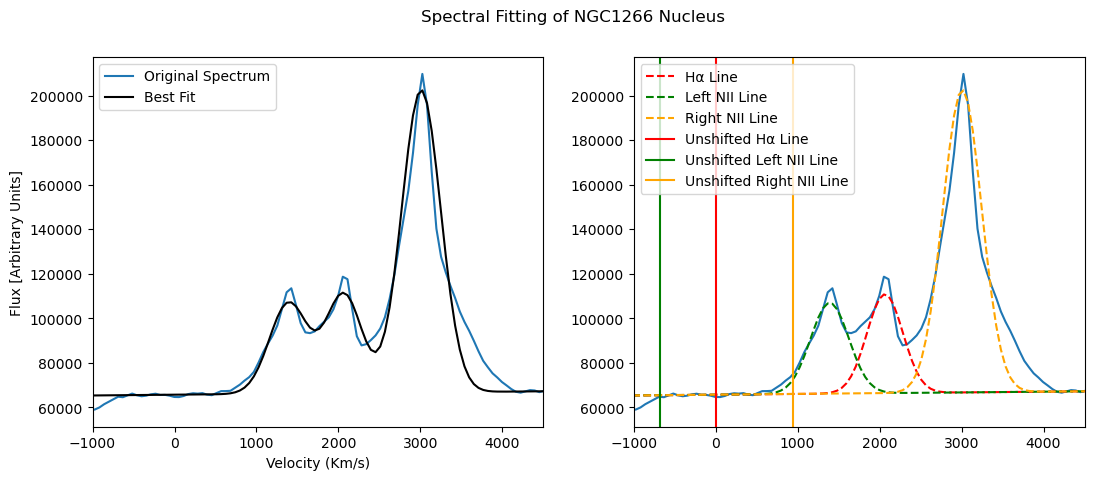

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(vel_nuc, fn_nuc, label='Original Spectrum')
ax[0].plot(vel_nuc, ffit.best_fit+cfit.eval(x=vel_nuc),
           color='k', label='Best Fit')
ax[0].set_xlim(-1000, 4500)

ax[0].set_xlabel("Velocity (Km/s)")
ax[0].set_ylabel("Flux [Arbitrary Units]")
ax[0].legend()


ax[1].plot(vel_nuc, fn_nuc)
ax[1].plot(vel_nuc, comps['g1_']+cfit.eval(x=vel_nuc),
           color='r', linestyle='--', label='Hα Line')
ax[1].plot(vel_nuc, comps['g2_']+cfit.eval(x=vel_nuc),
           color='g', linestyle='--', label='Left NII Line')
ax[1].plot(vel_nuc, comps['g3_']+cfit.eval(x=vel_nuc),
           color='orange', linestyle='--', label='Right NII Line')
ax[1].axvline(x=0, color='r', linestyle='-', label='Unshifted Hα Line')
ax[1].axvline(x=(wlNIIleft - wl0)/wl0 * const.c * 1.e-3, color='g',
              linestyle='-', label='Unshifted Left NII Line')
ax[1].axvline(x=(wlNIIright - wl0)/wl0 * const.c * 1.e-3,
              color='orange', linestyle='-', label='Unshifted Right NII Line')
ax[1].set_xlim(-1000, 4500)
ax[1].legend()

fig.suptitle(f"Spectral Fitting of {galaxy} Nucleus")
plt.show()